In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

Functions declaration

In [2]:
def detrend_dim(da, dim, degree):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = (da - fit)
    return da_det

def xr_mean_list(xr_list, esm):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    # esm = [a.source_id for a in nc_files]
    # esm = [nc_files]#

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        xr_list_new.append(content1)
    
    return xr_list_new

## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    return res

def cor_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #return cov,cor,slope,intercept,pval,stderr
    return cor

def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [3]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/MLR/'

#out_path = "D:/Data/CMIP6/RESULTS"

# -- Create directories
checkDir(out_path)

### Import regression data

In [4]:
# Open regression list data

import pickle

data_path = 'G:/Shared drives/Amazon_ENSO_work/analysis/'

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_DJF_coef_c_new"), "rb") as fp:   #Pickling
    coef_ridge_hist = pickle.load(fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_DJF_coef_c_new"), "rb") as fp:   #Pickling
    coef_ridge_ssp = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_DJF_pval_c_new"), "rb") as fp:   #Pickling
    pval_ridge_hist = pickle.load(fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_DJF_pval_c_new"), "rb") as fp:   #Pickling
    pval_ridge_ssp = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_DJF_r2_c_new"), "rb") as fp:   #Pickling
    r2_ridge_hist = pickle.load(fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_DJF_r2_c_new"), "rb") as fp:   #Pickling
    r2_ridge_ssp = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_enso_hist_1901-1960_DJF_ypred_c_new"), "rb") as fp:   #Pickling
    pred_ridge_hist = pickle.load(fp)
with open(os.path.join(data_path+"ridge_reg_enso_ssp_2041-2100_DJF_ypred_c_new"), "rb") as fp:   #Pickling
    pred_ridge_ssp = pickle.load(fp)

In [5]:
# MLR_b = ridge regression with residuals of pr,tas,enso,rsds,hfls \
# MLR_c = 5-fold CV Ridge Regression with resisuals of pr,tas,enso,rsds,hfls  \
# MLR_d = 5-fold CV Ridge Regression with resisuals of pr,tas,mrso,rsds and enso \
# MLR_e = 5-fold CV Ridge Regression with residuals of pr,tas,mrso,rsds,hfls and enso

# Because I forgot to concatenate the results of the MLR calculation 

coef_ridge_hist = [xr.concat([a.pr, a.tas, a.sst, a.rsds, a.hfls], dim = "coefficients") for a in coef_ridge_hist]
coef_ridge_ssp = [xr.concat([a.pr, a.tas, a.sst, a.rsds, a.hfls], dim = "coefficients") for a in coef_ridge_ssp]

pval_ridge_hist = [xr.concat([a.pr, a.tas, a.sst, a.rsds, a.hfls], dim = "pvalues") for a in pval_ridge_hist]
pval_ridge_ssp = [xr.concat([a.pr, a.tas, a.sst, a.rsds, a.hfls], dim = "pvalues") for a in pval_ridge_ssp]

pred_ridge_hist = [a.nep for a in pred_ridge_hist]
pred_ridge_ssp = [a.nep for a in pred_ridge_ssp]

In [6]:
esm = []
for filepath in sorted(glob.glob(os.path.join('E:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)   

### Import NEP data

In [7]:
data_path = 'E:/Data/analysis/'              

scenario = 'historical'
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_nep.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_nep.append(content)    

# Subsetting latitude
ds_hist_nep = [a.sel(lat=slice(-30,30)) for a in ds_hist_nep]
ds_ssp_nep = [a.sel(lat=slice(-30,30)) for a in ds_ssp_nep]

# Uniform calendar
for i, item in enumerate(ds_hist_nep):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_nep[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_nep):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_nep[i]['time'] = item.indexes['time'].to_datetimeindex()

# Select time periods
ds_hist_nep = [a.sel(time = slice("1901-01", "1960-12")) for a in ds_hist_nep]
ds_ssp_nep = [a.sel(time = slice("2041-01", "2100-12")) for a in ds_ssp_nep]

# Detrending of 1st order
ds_hist_nep = [detrend_dim(a, "time", 1) for a in ds_hist_nep]
ds_ssp_nep = [detrend_dim(a, "time", 1) for a in ds_ssp_nep]

# Resample from months to seasons
ds_hist_nep = [a.resample(time="QS", label='left').mean() for a in ds_hist_nep]
ds_ssp_nep = [a.resample(time="QS", label='left').mean() for a in ds_ssp_nep]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_nep[i] = ds_hist_nep[i].where(ds_hist_nep[i] != -3.7270379e-07)
        ds_ssp_nep[i] = ds_ssp_nep[i].where(ds_ssp_nep[i] != -6.18386321e-06)

# Correct for inverse NEP value in CESM2

esm = []
for filepath in sorted(glob.glob(os.path.join('E:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)   

for i,model in enumerate(esm):
        if model == "CESM2-WACCM":
                ds_hist_nep[i] = ds_hist_nep[i]*-1
                ds_ssp_nep[i] = ds_ssp_nep[i]*-1
        else:
                None

### Model Diversity and Predictor Diversity

Calculate Zonal means

In [7]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean()
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

In [9]:
# Zonal Mean in Amazon basin 
# Need to convert "object" type to "float64"

coef_ridge_hist_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in coef_ridge_hist]
coef_ridge_ssp_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in coef_ridge_ssp]

pval_ridge_hist_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in pval_ridge_hist]
pval_ridge_ssp_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in pval_ridge_ssp]

r2_ridge_hist_amz = [zonal_stat(a.astype("float64") , geodf).sel(region = 1) for a in r2_ridge_hist]
r2_ridge_ssp_amz = [zonal_stat(a.astype("float64") , geodf).sel(region = 1) for a in r2_ridge_ssp]

# NEP and NEP_pred to be initially considered as annual zonal averages
# Later on they will be averaged over time for every ESM
#  
pred_ridge_hist_amz = [zonal_stat(a.astype("float64") , geodf).sel(region = 1) for a in pred_ridge_hist]
pred_ridge_hist_amz = [a.rename("nep_pred") for a in pred_ridge_hist_amz]

pred_ridge_ssp_amz = [zonal_stat(a.astype("float64") , geodf).sel(region = 1) for a in pred_ridge_ssp]
pred_ridge_ssp_amz = [a.rename("nep_pred") for a in pred_ridge_ssp_amz]

ds_hist_nep_amz = [zonal_stat(a, geodf).sel(region = 1).sel(time = a.time.dt.season=="DJF") for a in ds_hist_nep]
ds_hist_nep_amz = [a.rename("nep") for a in ds_hist_nep_amz]

ds_ssp_nep_amz = [zonal_stat(a, geodf).sel(region = 1).sel(time = a.time.dt.season=="DJF") for a in ds_ssp_nep]
ds_ssp_nep_amz = [a.rename("nep") for a in ds_ssp_nep_amz]

Plot model performances

In [18]:
# Convert to pandas df to compute the model performances statistics 

# R2 pandas df 
test_hist = xr.concat(r2_ridge_hist_amz, dim = "esm").to_dataframe(name = "historical").drop(columns = "region")
test_hist = test_hist.rename(index=dict(zip(test_hist.index, esm)))
# test_hist = test_hist.groupby(esm).mean()
test_ssp = xr.concat(r2_ridge_ssp_amz, dim = "esm").to_dataframe(name = "ssp585").drop(columns = "region")
test_ssp = test_ssp.rename(index=dict(zip(test_ssp.index, esm)))
# test_ssp = test_ssp.groupby(esm).mean()

test_r2 = pd.concat([test_hist,test_ssp], axis = 1); test_r2["esm"] = test_r2.index
test_r2 = pd.melt(test_r2, id_vars="esm", var_name="scenario")

# NEP & NEP predicted pandas df 
test_nep_hist = xr.concat(ds_hist_nep_amz, dim = "esm").to_dataframe()
test_nep_hist = test_nep_hist.reset_index().drop(columns = ["esm","time","region"])
test_pred_hist = xr.concat(pred_ridge_hist_amz, dim = "esm").to_dataframe()
test_pred_hist = test_pred_hist.reset_index().drop(columns = ["esm","time","region"])

test_nep_ssp = xr.concat(ds_ssp_nep_amz, dim = "esm").to_dataframe()
test_nep_ssp = test_nep_ssp.reset_index().drop(columns = ["esm","time","region"])
test_pred_ssp = xr.concat(pred_ridge_ssp_amz, dim = "esm").to_dataframe()
test_pred_ssp = test_pred_ssp.reset_index().drop(columns = ["esm","time","region"])


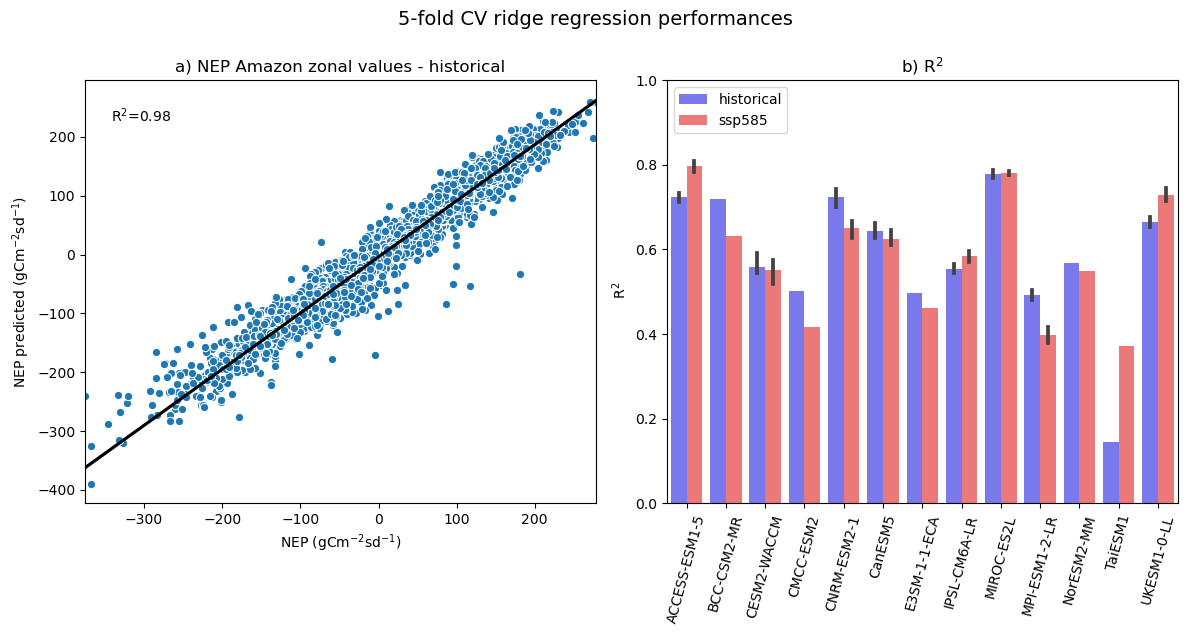

In [110]:
import seaborn as sns
from scipy import stats

fig = plt.figure(figsize=(12, 6))

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(121)
ax0 = sns.scatterplot("nep", 'nep_pred', data=pd.concat([test_nep_hist,test_pred_hist], axis = 1), legend = False)
ax0 = sns.regplot(x="nep", y='nep_pred', data=pd.concat([test_nep_hist,test_pred_hist], axis = 1), scatter=False, line_kws={"color": "black"})
ax0.set(xlabel="NEP" + ' (gCm$^{-2}$sd$^{-1}$)', ylabel="NEP predicted" + ' (gCm$^{-2}$sd$^{-1}$)')
ax0.text(.05, .9, 'R$^2$={:.2f}'.format(stats.linregress(pd.concat([test_nep_hist,test_pred_hist], axis = 1)['nep'],pd.concat([test_nep_hist,test_pred_hist], axis = 1)["nep_pred"]).rvalue),
            transform=ax0.transAxes, fontsize = 10)
ax0.set_title("a) NEP Amazon zonal values - historical")


ax1 = fig.add_subplot(122)
ax1 = sns.barplot(
    data=test_r2, hue = "scenario",# errorbar=("pi", 50),
    x="esm", y="value",
    palette=['blue', 'red'], alpha=.6, 
)
ax1.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax1.set_xlabel("")
ax1.set_ylabel(" R$^2$")
ax1.set_ylim(0,1)
ax1.legend(loc='upper left', fontsize = 10)
ax1.set_title("b) R$^2$")

fig.tight_layout()
title = "5-fold CV ridge regression performances"
fig.suptitle(title, y = 1.05, fontsize = 14)

output_file = os.path.join(out_path, title) + "_c.png"
plt.savefig(output_file, bbox_inches='tight')


In [31]:
# Average time values of NEP and NEP-predicted 

ds_hist_nep_amz= [a.mean(dim = "time") for a in ds_hist_nep_amz]
ds_ssp_nep_amz= [a.mean(dim = "time") for a in ds_ssp_nep_amz]

pred_ridge_hist_amz= [a.mean(dim = "time") for a in pred_ridge_hist_amz]
pred_ridge_ssp_amz= [a.mean(dim = "time") for a in pred_ridge_ssp_amz]

In [32]:
# The order of the coefficients is specified in the section "Import saved data"

# Separate predictors HIST
coef_ridge_hist_pr_amz = [a.sel(coefficients = 0) for a in coef_ridge_hist_amz]
coef_ridge_hist_tas_amz = [a.sel(coefficients = 1).rename("tas") for a in coef_ridge_hist_amz]
# coef_ridge_hist_mrso_amz = [a.sel(coefficients = 2).rename("mrso") for a in coef_ridge_hist_amz]
coef_ridge_hist_enso_amz = [a.sel(coefficients = 2).rename("enso") for a in coef_ridge_hist_amz]
coef_ridge_hist_rsds_amz = [a.sel(coefficients = 3).rename("rsds") for a in coef_ridge_hist_amz]
coef_ridge_hist_hfls_amz = [a.sel(coefficients = 4).rename("hfls") for a in coef_ridge_hist_amz]

r2_ridge_hist_amz = [a.rename("r2") for a in r2_ridge_hist_amz]

# Separate predictors SSP
coef_ridge_ssp_pr_amz = [a.sel(coefficients = 0) for a in coef_ridge_ssp_amz]
coef_ridge_ssp_tas_amz = [a.sel(coefficients = 1).rename("tas") for a in coef_ridge_ssp_amz]
# coef_ridge_ssp_mrso_amz = [a.sel(coefficients = 2).rename("mrso") for a in coef_ridge_ssp_amz]
coef_ridge_ssp_enso_amz = [a.sel(coefficients = 2).rename("enso") for a in coef_ridge_ssp_amz]
coef_ridge_ssp_rsds_amz = [a.sel(coefficients = 3).rename("rsds") for a in coef_ridge_ssp_amz]
coef_ridge_ssp_hfls_amz = [a.sel(coefficients = 4).rename("hfls") for a in coef_ridge_ssp_amz]

r2_ridge_ssp_amz = [a.rename("r2") for a in r2_ridge_ssp_amz]

Convert xarrays to pandas DF

In [49]:
# Convert to pandas dataframe

esm = []
for filepath in sorted(glob.glob(os.path.join('E:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)    

import pandas as pd

df_coef_ridge_hist_pr = xr.concat(coef_ridge_hist_pr_amz, dim = "esm").to_dataframe(); df_coef_ridge_hist_pr = df_coef_ridge_hist_pr.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_hist_pr.index, esm)))
df_coef_ridge_hist_tas = xr.concat(coef_ridge_hist_tas_amz, dim = "esm").to_dataframe(); df_coef_ridge_hist_tas = df_coef_ridge_hist_tas.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_hist_tas.index, esm)))
df_coef_ridge_hist_enso = xr.concat(coef_ridge_hist_enso_amz, dim = "esm").to_dataframe(); df_coef_ridge_hist_enso = df_coef_ridge_hist_enso.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_hist_enso.index, esm)))
df_coef_ridge_hist_rsds = xr.concat(coef_ridge_hist_rsds_amz, dim = "esm").to_dataframe(); df_coef_ridge_hist_rsds = df_coef_ridge_hist_rsds.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_hist_rsds.index, esm)))
# df_coef_ridge_hist_mrso = xr.concat(coef_ridge_hist_mrso_amz, dim = "esm").to_dataframe(); df_coef_ridge_hist_mrso = df_coef_ridge_hist_mrso.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_hist_mrso.index, esm)))
df_coef_ridge_hist_hfls = xr.concat(coef_ridge_hist_hfls_amz, dim = "esm").to_dataframe(); df_coef_ridge_hist_hfls = df_coef_ridge_hist_hfls.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_hist_hfls.index, esm)))
# df_r2_ridge_hist = xr.concat(r2_ridge_hist, dim = "esm").to_dataframe(); df_r2_ridge_hist = df_r2_ridge_hist.drop(columns = "region").rename(index=dict(zip(df_r2_ridge_hist.index, esm)))
df_hist_nep = xr.concat(ds_hist_nep_amz, dim = "esm").to_dataframe(); df_hist_nep = df_hist_nep.drop(columns = "region").rename(index=dict(zip(df_hist_nep.index, esm)))
df_pred_ridge_hist = xr.concat(pred_ridge_hist_amz, dim = "esm").to_dataframe(); df_pred_ridge_hist = df_pred_ridge_hist.drop(columns = "region").rename(index=dict(zip(df_pred_ridge_hist.index, esm)))

df_amz_hist = pd.concat([df_pred_ridge_hist, df_hist_nep, df_coef_ridge_hist_pr, df_coef_ridge_hist_tas, df_coef_ridge_hist_enso, df_coef_ridge_hist_rsds, df_coef_ridge_hist_hfls], axis = 1)

In [50]:
# Convert to pandas dataframe
import pandas as pd

df_coef_ridge_ssp_pr = xr.concat(coef_ridge_ssp_pr_amz, dim = "esm").to_dataframe(); df_coef_ridge_ssp_pr = df_coef_ridge_ssp_pr.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_pr.index, esm)))
df_coef_ridge_ssp_tas = xr.concat(coef_ridge_ssp_tas_amz, dim = "esm").to_dataframe(); df_coef_ridge_ssp_tas = df_coef_ridge_ssp_tas.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_tas.index, esm)))
df_coef_ridge_ssp_enso = xr.concat(coef_ridge_ssp_enso_amz, dim = "esm").to_dataframe(); df_coef_ridge_ssp_enso = df_coef_ridge_ssp_enso.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_enso.index, esm)))
df_coef_ridge_ssp_rsds = xr.concat(coef_ridge_ssp_rsds_amz, dim = "esm").to_dataframe(); df_coef_ridge_ssp_rsds = df_coef_ridge_ssp_rsds.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_rsds.index, esm)))
# df_coef_ridge_ssp_mrso = xr.concat(coef_ridge_ssp_mrso_amz, dim = "esm").to_dataframe(); df_coef_ridge_ssp_mrso = df_coef_ridge_ssp_mrso.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_mrso.index, esm)))
df_coef_ridge_ssp_hfls = xr.concat(coef_ridge_ssp_hfls_amz, dim = "esm").to_dataframe(); df_coef_ridge_ssp_hfls = df_coef_ridge_ssp_hfls.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_hfls.index, esm)))
# df_r2_ridge_ssp = xr.concat(r2_ridge_ssp, dim = "esm").to_dataframe(); df_r2_ridge_ssp = df_r2_ridge_ssp.drop(columns = "region").rename(index=dict(zip(df_r2_ridge_ssp.index, esm)))
df_ssp_nep = xr.concat(ds_ssp_nep_amz, dim = "esm").to_dataframe(); df_ssp_nep = df_ssp_nep.drop(columns = "region").rename(index=dict(zip(df_ssp_nep.index, esm)))
df_pred_ridge_ssp = xr.concat(pred_ridge_ssp_amz, dim = "esm").to_dataframe(); df_pred_ridge_ssp = df_pred_ridge_ssp.drop(columns = "region").rename(index=dict(zip(df_pred_ridge_ssp.index, esm)))

df_amz_ssp = pd.concat([df_pred_ridge_ssp, df_ssp_nep, df_coef_ridge_ssp_pr, df_coef_ridge_ssp_tas, df_coef_ridge_ssp_enso, df_coef_ridge_ssp_rsds, df_coef_ridge_ssp_hfls], axis = 1)

Barplots of coefficients

In [51]:
df_amz_hist["esm"] = df_amz_hist.index
df_amz_hist_long = pd.melt(df_amz_hist,id_vars="esm", var_name="effect"); df_amz_hist_long["scenario"] = "hist"
df_amz_ssp["esm"] = df_amz_ssp.index
df_amz_ssp_long = pd.melt(df_amz_ssp,id_vars="esm", var_name="effect"); df_amz_ssp_long["scenario"] = "ssp"

df = pd.concat([df_amz_hist_long, df_amz_ssp_long], axis = 0)

df_delta = (df_amz_hist.drop(columns=["esm"]) - df_amz_ssp.drop(columns=["esm"])); df_delta["esm"] = df_delta.index
df_delta = pd.melt(df_delta, id_vars="esm", var_name="effect");


In [141]:
df.to_csv(os.path.join(out_path,"df_coeff_mlr.csv"))

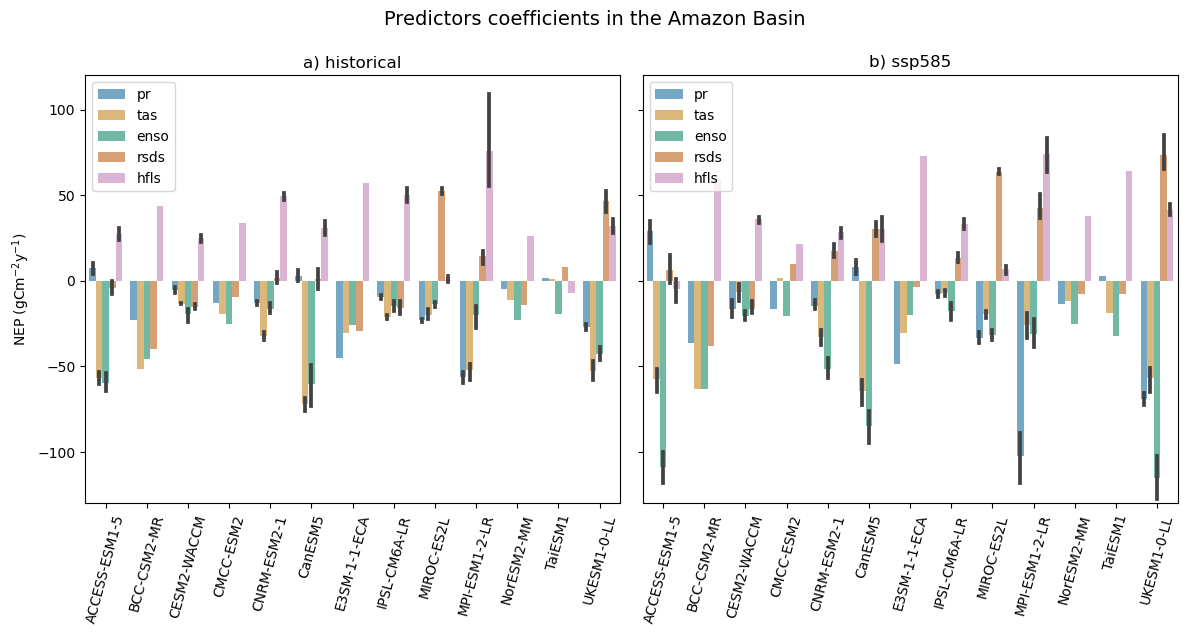

In [137]:
fig = plt.figure(figsize=(12, 6))

data = df[(df['effect'] != 'nep_pred') & (df['effect'] != 'nep')].copy()

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(121)
ax0 = sns.barplot(
    data=data[data['scenario'] == 'hist'].rename(columns={'effect': 'variable'}), hue="variable",# errorbar=("pi", 50),
    x="esm", y="value",
    palette='colorblind', alpha=.6, 
)
ax0.set_ylim(-130, 120)
ax0.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("NEP (gCm$^{-2}$y$^{-1}$)")
ax0.set_title("a) historical")

ax1 = fig.add_subplot(122)
ax1 = sns.barplot(
    data=data[data['scenario'] == 'ssp'].rename(columns={'effect': 'variable'}), hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    palette='colorblind', alpha=.6, 
)
ax1.set_ylim(-130, 120)
ax1.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax1.set_yticklabels("")
ax1.legend()
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("b) ssp585")

fig.tight_layout()
title = 'Predictors coefficients in the Amazon Basin'
fig.suptitle(title, y = 1.05, fontsize = 14)
output_file = os.path.join(out_path, title) + "_c.png"


# g = sns.catplot(
#     data=df[(df['effect'] != 'nep_pred') & (df['effect'] != 'nep')], kind="bar", col = "scenario",# errorbar=("pi", 50),
#     x="esm", y="value", hue="effect",
#     palette='colorblind', alpha=.6, height=6
# )

# # g.despine(left=True)
# title = 'Predictors coefficients in the Amazon Basin'
# g.fig.suptitle(title, y = 1.05)
# g.set_xticklabels(rotation = 75)
# g.set_axis_labels("", "NEP (gCm$^{-2}$y$^{-1}$)")
# g.set_titles("a) historical", "b) ssp585")
# g.fig.set_figwidth(12,8)
# output_file = os.path.join(out_path, title) + ".png"
plt.savefig(output_file, bbox_inches='tight')

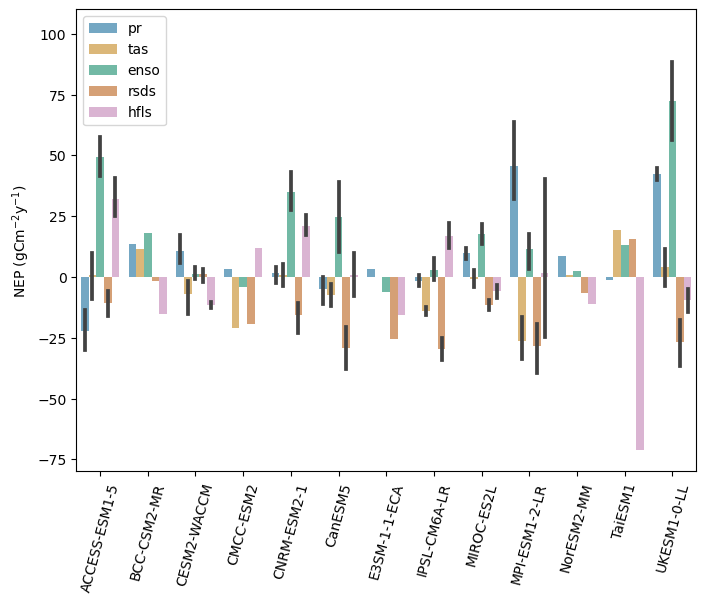

In [135]:
import seaborn as sns

fig = plt.figure(figsize=(8, 6))

data = df_delta[(df_delta['effect'] != 'nep_pred') & (df_delta['effect'] != 'nep')].copy()

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(111)

ax0 = sns.barplot(
    data=data.rename(columns={'effect': 'variable'}), hue="variable",# errorbar=("pi", 50),
    x="esm", y="value",
    palette='colorblind', alpha=.6, 
)
ax0.set_ylim(-80, 110)
ax0.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax0.legend(loc='upper left', fontsize = 10, )
ax0.set_xlabel("")
ax0.set_ylabel("NEP (gCm$^{-2}$y$^{-1}$)")

# g.despine(left=True)
title = 'Predictors coefficients in the Amazon Basin - Delta'
g.fig.suptitle(title, y = 1.05)
g.set_xticklabels(rotation = 75)
g.set_axis_labels("", "NEP (gCm$^{-2}$y$^{-1}$)")
g.fig.set_figwidth(10,8)
output_file = os.path.join(out_path, title) + ".png"


# g = sns.catplot(
#     data=df_delta[(df_delta['effect'] != 'nep_pred') & (df_delta['effect'] != 'nep')], kind="bar",# col = "scenario",
#     x="esm", y="value", hue="effect",
#     palette='colorblind', alpha=.6, height=6
# )

# # g.despine(left=True)
# title = 'Predictors coefficients in the Amazon Basin - Delta'
# g.fig.suptitle(title, y = 1.05)
# g.set_xticklabels(rotation = 75)
# g.set_axis_labels("", "NEP (gCm$^{-2}$y$^{-1}$)")
# g.fig.set_figwidth(10,8)
# output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')

Barplots of NEP_pred vs NEP

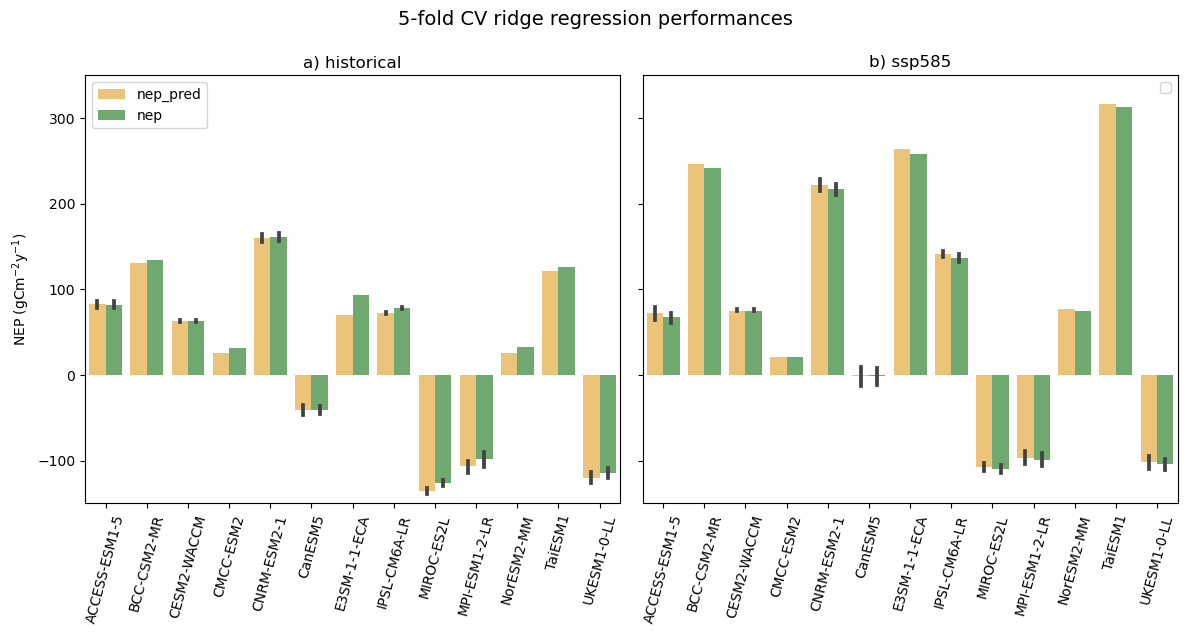

In [113]:
fig = plt.figure(figsize=(12, 6))

data = df[(df['effect'] == 'nep_pred') | (df['effect'] == 'nep')].copy()

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(121)
ax0 = sns.barplot(
    data=data[data['scenario'] == 'hist'].rename(columns={'effect': 'variable'}), hue="variable",# errorbar=("pi", 50),
    x="esm", y="value",
    palette=['orange', 'green'], alpha=.6, 
)
ax0.set_ylim(-150, 350)
ax0.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("NEP (gCm$^{-2}$y$^{-1}$)")
ax0.set_title("a) historical")

ax1 = fig.add_subplot(122)
ax1 = sns.barplot(
    data=data[data['scenario'] == 'ssp'].rename(columns={'effect': 'variable'}), hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    palette=['orange', 'green'], alpha=.6, 
)
ax1.set_ylim(-150, 350)
ax1.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax1.set_yticklabels("")
ax1.legend("")
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("b) ssp585")

fig.tight_layout()
title = 'Predictors coefficients in the Amazon Basin'
fig.suptitle(title, y = 1.05, fontsize = 14)

output_file = os.path.join(out_path, title) + "_c.png"
plt.savefig(output_file, bbox_inches='tight')


# g = sns.catplot(
#     data=df[(df['effect'] == 'nep_pred') | (df['effect'] == 'nep')].rename(columns={'effect': 'variable'}),
#     kind="bar", col = "scenario",# errorbar=("pi", 50),
#     x="esm", y="value", hue="variable",
#     palette=['orange', 'green'], alpha=.6, height=6
# )


# # g.despine(left=True)
# title = 'regression model performance in the in the Amazon Basin'
# g.fig.suptitle(title, y = 1.05)
# g.set_xticklabels(rotation = 75)
# g.set_axis_labels("", "NEP (gCm$^{-2}$y$^{-1}$)")
# g.fig.set_figwidth(12,8)


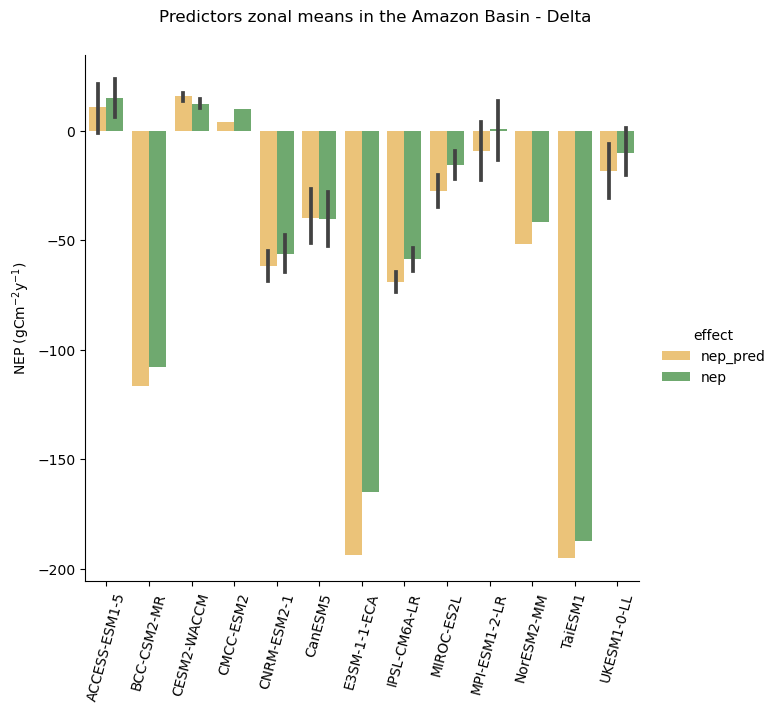

In [118]:
import seaborn as sns

g = sns.catplot(
    data=df_delta[(df_delta['effect'] == 'nep_pred') | (df_delta['effect'] == 'nep')], kind="bar",# col = "scenario",
    x="esm", y="value", hue="effect",
    palette=['orange', 'green'], alpha=.6, height=6
)

# g.despine(left=True)
title = 'regression model performance in the in the Amazon Basin'
g.fig.suptitle(title, y = 1.05)
g.set_xticklabels(rotation = 75)
g.set_axis_labels("", "NEP (gCm$^{-2}$y$^{-1}$)")
g.fig.set_figwidth(8,5)
output_file = os.path.join(out_path, title) + ".png"
plt.savefig(output_file, bbox_inches='tight')

PCA

In [58]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_amz_ssp.drop(columns = ["esm", "nep_pred", "nep"]))

pca_ssp_scores = pca.transform(df_amz_ssp.drop(columns = ["esm", "nep_pred", "nep"]))
pca_ssp_loadings = pca.components_[:2].T

pca_ssp = pd.DataFrame(pca_ssp_scores).rename(columns = {0:"PC1", 1:"PC2"})
pca_ssp = pca_ssp.rename(index=dict(zip(pca_ssp.index, esm)))
pca_ssp = pd.concat([pca_ssp, df_amz_ssp.drop(columns = ["esm", "nep_pred", "nep"])], axis = 1)

print("Variance explained is:", pca.explained_variance_ratio_)
print("PC coefficients are:", pca.components_)

Variance explained is: [0.46383637 0.37702527]
PC coefficients are [[-0.70608771  0.26422082  0.51697515  0.15797184  0.37337528]
 [-0.4461494  -0.3594516  -0.62539233  0.52702687  0.05359455]]


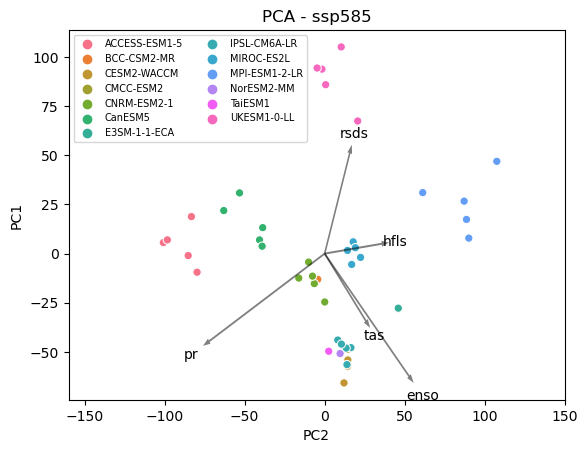

In [66]:
arrows = pca_ssp_loadings * np.abs(pca_ssp_scores).max(axis=0)
features = df_amz_ssp.drop(columns = ["esm", "nep_pred", "nep"]).columns.values


fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.scatterplot("PC1", "PC2", data=pca_ssp, hue=pca_ssp.index)

for i, arrow in enumerate(arrows):
    plt.arrow(0, 0, *arrow, color='k', alpha=0.5, width=1, ec='none',
              length_includes_head=True)
    plt.text(*(arrow * 1.1), features[i],
             ha='center', va='center')

ax.set(xlabel= "PC2", ylabel='PC1')
title= "PCA - ssp585"
ax.set_title(title)
ax.set_xlim(-160, 150)
ax.legend(loc='upper left', ncol=2, fontsize = 7)
output_file = os.path.join(out_path, title) + ".png"
plt.savefig(output_file, bbox_inches='tight')


Scatterplot of NEP vs coefficients

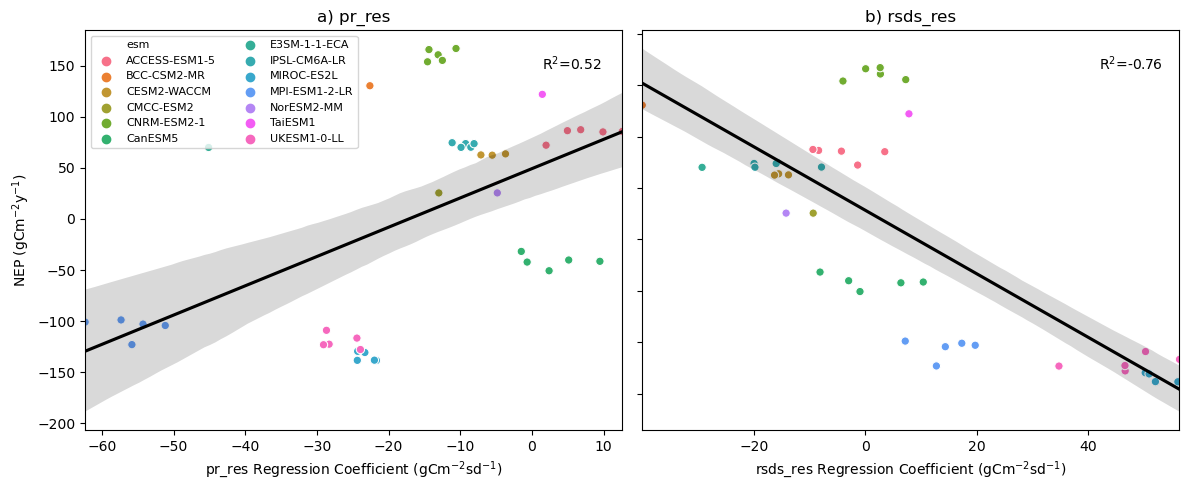

In [68]:
import seaborn as sns
from scipy import stats

fig = plt.figure(figsize=(12, 5))

ax0 = fig.add_subplot(121)
ax0 = sns.scatterplot("pr", 'nep_pred', data=df_amz_hist, hue=df_amz_hist.index)
ax0 = sns.regplot(x="pr", y='nep_pred', data=df_amz_hist, scatter=False, line_kws={"color": "black"})
ax0.set(xlabel="pr_res" + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel='NEP (gCm$^{-2}$y$^{-1}$)')
ax0.legend(loc='upper left', ncol=2, fontsize = 8)
ax0.text(.85, .9, 'R$^2$={:.2f}'.format(stats.linregress(df_amz_hist['nep_pred'],df_amz_hist["pr"]).rvalue),
            transform=ax0.transAxes, fontsize = 10)
ax0.label_outer()
ax0.set_title("a) pr_res")

ax = fig.add_subplot(122)
ax = sns.scatterplot("rsds", 'nep_pred', data=df_amz_hist, hue=df_amz_hist.index, legend = False)
ax = sns.regplot(x="rsds", y='nep_pred', data=df_amz_hist, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="rsds_res" + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel=None)
ax.text(.85, .9, 'R$^2$={:.2f}'.format(stats.linregress(df_amz_hist['nep_pred'],df_amz_hist["rsds"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.label_outer()
ax.set_title("b) rsds_res")

fig.tight_layout()
title= "model diversity - historical, pr + rsds"
output_file = os.path.join(out_path, title) + "_c_nep_pred.png"
plt.savefig(output_file, bbox_inches='tight')

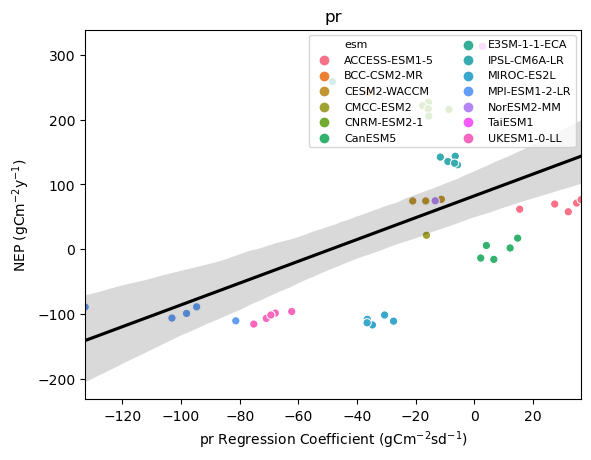

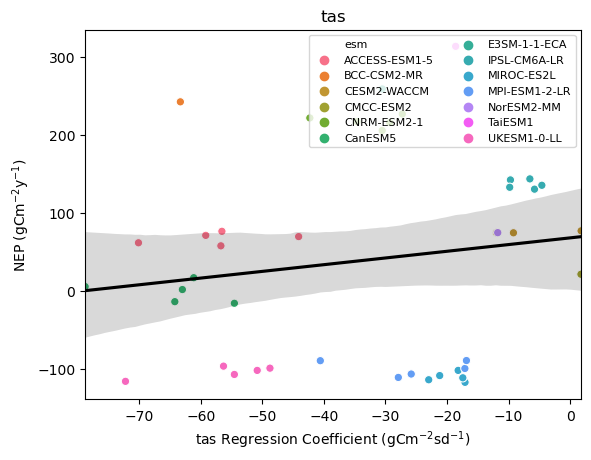

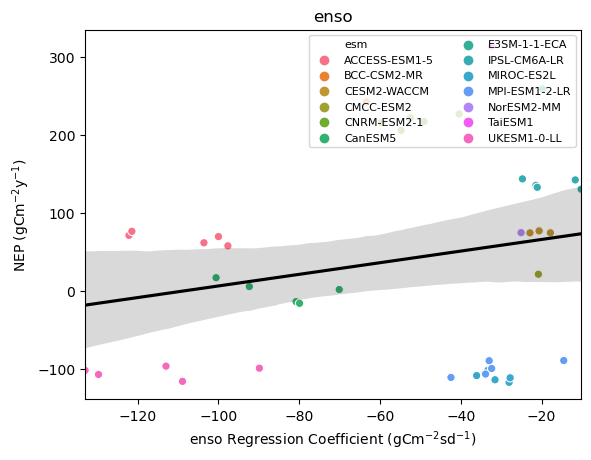

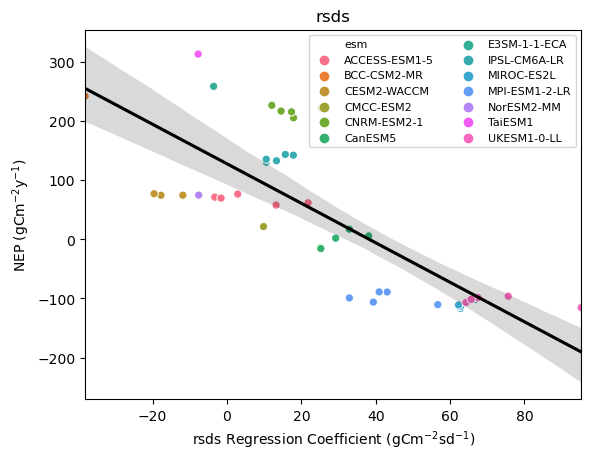

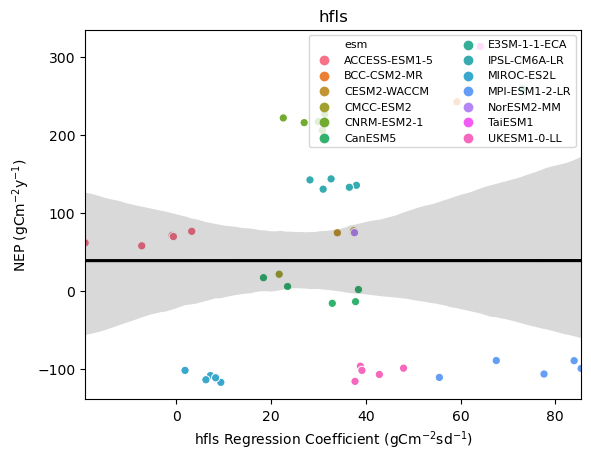

In [73]:
import seaborn as sns

for predictor in ["pr", "tas", "enso", "rsds", "hfls"]:
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax = sns.scatterplot(predictor, 'nep', data=df_amz_ssp, hue=df_amz_ssp.index)
    ax = sns.regplot(x=predictor, y='nep', data=df_amz_ssp, scatter=False, line_kws={"color": "black"})
    ax.set(xlabel=predictor + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel='NEP (gCm$^{-2}$y$^{-1}$)')
    title= "model diversity - ssp585 " + predictor
    ax.set_title(predictor)
    ax.legend(loc='upper right', ncol=2, fontsize = 8)
    output_file = os.path.join(out_path, title) + "_c.png"
    plt.savefig(output_file, bbox_inches='tight')

### Plot coefficients and R2

In [77]:
# Define esm

esm = []
for filepath in sorted(glob.glob(os.path.join('E:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)    

# Mean response of ESM
coef_ridge_hist = xr_mean_list(coef_ridge_hist, esm)
coef_ridge_ssp = xr_mean_list(coef_ridge_ssp, esm)

pval_ridge_hist = xr_mean_list(pval_ridge_hist, esm)
pval_ridge_ssp = xr_mean_list(pval_ridge_ssp, esm)

r2_ridge_hist = xr_mean_list(r2_ridge_hist, esm)
r2_ridge_ssp = xr_mean_list(r2_ridge_ssp, esm)

pred_ridge_hist = xr_mean_list(pred_ridge_hist, esm)
pred_ridge_ssp = xr_mean_list(pred_ridge_ssp, esm)

In [78]:
pval_ridge_hist_fdr = []
pval_ridge_ssp_fdr = []
for i, item in enumerate(pval_ridge_hist):
    reject, xpvals_corrected_hist = xr_multipletest(pval_ridge_hist[i])
    reject, xpvals_corrected_ssp = xr_multipletest(pval_ridge_ssp[i])
    pval_ridge_hist_fdr.append(xpvals_corrected_hist)
    pval_ridge_ssp_fdr.append(xpvals_corrected_ssp)

In [79]:
# Delta_NEP sensitivity to pr and tas
delta_coef_ridge = [] 
for i in np.arange(13): #enumerate(esm):
    content = (coef_ridge_ssp[i] - coef_ridge_hist[i])
    delta_coef_ridge.append(content)

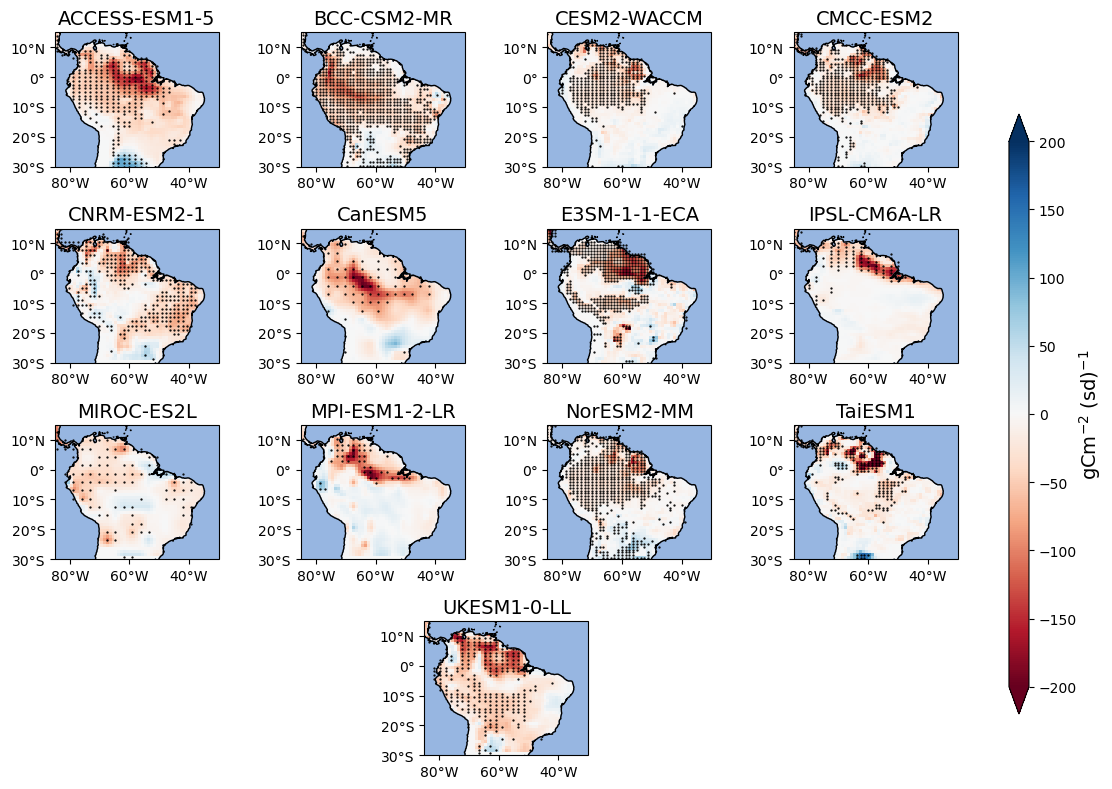

In [133]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

seas = "DJF"

# --- Define data to plot
to_plot = "coef_hist"; predictor = "enso"

if to_plot == "coef_hist":
    data_plot = coef_ridge_hist.copy()
    hatch_plot = pval_ridge_hist_fdr.copy()
    cbar_label = 'gCm$^{-2}$ (sd)$^{-1}$'
    cmap = "RdBu"
    title = '\u03B3NEP_enso historical - Ridge Regression - ENSO -'  + seas + '_1901-1960'

if to_plot == "coef_ssp":
    data_plot = coef_ridge_ssp.copy()
    hatch_plot = pval_ridge_ssp_fdr.copy()
    cbar_label = 'gCm$^{-2}$ (sd)$^{-1}$'
    cmap = "RdBu"
    title = '\u03B3NEP_enso ssp585 - Ridge Regression - ENSO -'  + seas + '_2041-2100'

if to_plot == "delta":
    data_plot = delta_coef_ridge.copy()
    cbar_label = 'gCm$^{-2}$ (sd)$^{-1}$'
    cmap = "BrBG"
    title = '\u0394\u03B3NEP_enso ssp585 - Ridge Regression - ENSO -'  + seas

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 8

# --- Colorbar configuration#
min_value, max_value = None, None                                       #automatic colorbar limits
cbar_position = "top"
cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 0
}

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if predictor == "pr":
        data_plot[i] = data_plot[i].sel(coefficients = 0); hatch_plot[i] = hatch_plot[i].sel(pvalues = 0)
    if predictor == "tas":
        data_plot[i] = data_plot[i].sel(coefficients = 1); hatch_plot[i] = hatch_plot[i].sel(pvalues = 1)
    if predictor == "enso":
        data_plot[i] = data_plot[i].sel(coefficients = 2); hatch_plot[i] = hatch_plot[i].sel(pvalues = 2)
    if predictor == "rsds":
        data_plot[i] = data_plot[i].sel(coefficients = 3); hatch_plot[i] = hatch_plot[i].sel(pvalues = 3)
    if predictor == "hfls":
        data_plot[i] = data_plot[i].sel(coefficients = 4); hatch_plot[i] = hatch_plot[i].sel(pvalues = 4)

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

    lons = hatch_plot[i].lon
    lats = hatch_plot[i].lat
    pearson_r_single_95x =[]
    pearson_r_single_95y =[] 
    for y,itemy in enumerate(lats):
        for x,itemx in enumerate(lons):
            if hatch_plot[i][x][y]<0.05:                   # Define the significance level of Mann Whitney test                       
                contentx =itemx                                          # If < sign significant gridcells, if > sign not-significant gridcells
                contenty =itemy
                pearson_r_single_95x.append(contentx)
                pearson_r_single_95y.append(contenty)

    # map1 = ax.pcolormesh(lons, lats, data_plot[i].sel(coefficients = 0), vmin=min_value, vmax=max_value, transform = ccrs.PlateCarree(), cmap=cmap) 
    map1 = data_plot[i].plot.pcolormesh(ax = ax, x = "lon", y = "lat", vmin=-200, vmax=200, cmap=cmap, transform = ccrs.PlateCarree(), add_colorbar = False, add_labels = False)
    sign = np.ma.masked_greater(hatch_plot[i], 0.05)

    # map = ax.pcolor(lats, lons, sign, hatch = '///', transform = ccrs.PlateCarree(), alpha = 0.5)
    ax.plot(pearson_r_single_95x, pearson_r_single_95y, "o", transform = ccrs.PlateCarree(), markersize = 0.6, color="black")

    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.coastlines()
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  

    ## XtickLabels alternative 1
    # Longitude labels
    ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    #ax.set_xlabel(xlabel, **xlabel_fontstyle)
    # Latitude labels
    ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  


# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.75])                     # Left, Bottom, Width, Height
clb = fig.colorbar(map1, cax=cbar_ax, extend="both")
clb.set_label(cbar_label, **cbar_fontstyle)
# clb.ax.set_yticklabels(np.arange(-6,9,2))

# --- Output file
output_file = os.path.join(out_path, title) + "_c.png"
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

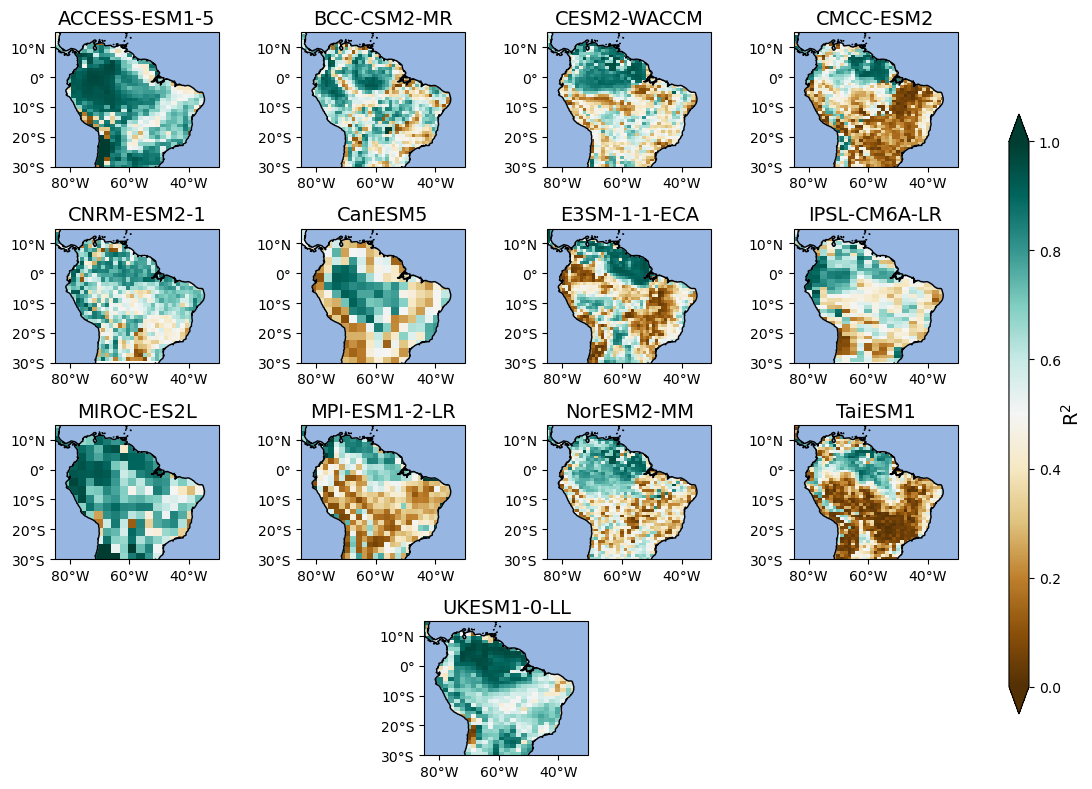

In [84]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# --- Define data to plot
to_plot = "r2_ssp"

if to_plot == "r2_hist":
    data_plot = r2_ridge_hist.copy()
    cbar_label = 'R$^{2}$'
    cmap = "BrBG"
    title = 'R2 historical - Ridge Regression - ENSO -'  + seas + '_1901-1960'

if to_plot == "r2_ssp":
    data_plot = r2_ridge_ssp.copy()
    cbar_label = 'R$^{2}$'
    cmap = "BrBG"
    title = 'R2 ssp585 - Ridge Regression - ENSO -'  + seas + '_2041-2100'

if to_plot == "pred_hist":
    data_plot = pred_ridge_hist
    cbar_label = ''
    cmap = "RdYlGn"
    title = 'Pred_NEP historical - Ridge Regression - ENSO -'  + seas

if to_plot == "pred_ssp":
    data_plot = pred_ridge_ssp
    cbar_label = ''
    cmap = "RdYlGn"
    title = 'Pred_NEP ssp585 - Ridge Regression - ENSO -'  + seas

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30 
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 8

# --- Colorbar configuration#
min_value, max_value = None, None                                       #automatic colorbar limits
cbar_position = "top"
cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 0
}

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

    # lons = data_plot[i].lon
    # lats = data_plot[i].lat
    # map1 = ax.pcolormesh(lons, lats, data_plot[i], vmin=0, vmax=1, transform = ccrs.PlateCarree(), cmap=cmap) 
    map1 = data_plot[i].astype(np.float64).plot.pcolormesh(ax = ax, x = "lon", y = "lat", vmin=0, vmax=1, cmap=cmap, transform = ccrs.PlateCarree(), add_colorbar = False, add_labels = False)

    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.coastlines()
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  

    ## XtickLabels alternative 1
    # Longitude labels
    ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    #ax.set_xlabel(xlabel, **xlabel_fontstyle)
    # Latitude labels
    ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  


# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.75])                     # Left, Bottom, Width, Height
clb = fig.colorbar(map1, cax=cbar_ax, extend="both")
clb.set_label(cbar_label, **cbar_fontstyle)
# clb.ax.set_yticklabels(np.arange(-6,9,2))

# --- Output file
output_file = os.path.join(out_path, title) + "_c.png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()